In [32]:
import numpy as np
import time
import matplotlib.pyplot as plt
import PyMieScatt as ps
import subprocess
import math
import sys
import pandas as pd
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans

indreal, indimg, sig = 1.33, 1E-9, 1.8 # ne pas modifier pour l'instant

particle_name = 'water-sigma1.8bae'

In [33]:
def BAE_lognormal_fn(diam, sig, indreal, indimg) :
    Q_1064= ps.Mie_Lognormal(complex(indreal,indimg),1064,sig,diam,1e3,asDict=True, lower=0.1, upper=30000) 
    Q_532=ps.Mie_Lognormal(complex(indreal,indimg),532,sig,diam,1e3,asDict=True, lower=0.1, upper=30000) 
    Q_355=ps.Mie_Lognormal(complex(indreal,indimg),355,sig,diam,1e3,asDict=True, lower=0.1, upper=30000) 

    BAE_1064_532 = -np.log(Q_1064['Bback']/ Q_532['Bback'])/np.log(1064/532)
    BAE_532_355 = -np.log(Q_532['Bback']/ Q_355['Bback'])/np.log(532/355)
    BAE_1064_355 = -np.log(Q_1064['Bback']/ Q_355['Bback'])/np.log(1064/355)

    return BAE_1064_532, BAE_532_355, BAE_1064_355

In [34]:
# Importation des données (Calculé par le GMM, ne pas oublier de télécharger les fichiers csv)
df_BAE = np.array(pd.read_csv("BAElognorm.csv"))
df_diam = np.array(pd.read_csv("diam.csv"))

#définitions du jeu de données pour les différents models
diam_entree = df_diam[0:714] # Charger les données diamètre

BAE_1064_532 = df_BAE[0:714,0] #On rogne à 715 points car au dessus d'un diamètres de 10^4 cela n'a plus d'intérêt
BAE_532_355 = df_BAE[0:714,1]
BAE_1064_355 = df_BAE[0:714,2]
BAEs = np.array([BAE_1064_532, BAE_532_355, BAE_1064_355]).T

In [163]:
# Génération des données (environ 5 mins)
diam_entree = np.logspace(0, 4, 60) # Charger les données diamètre

BAEs = [BAE_lognormal_fn(diam, sig, indreal, indimg) for diam in diam_entree]

BAE_1064_532 = [BAE[0] for BAE in BAEs]
BAE_532_355 = [BAE[1] for BAE in BAEs]
BAE_1064_355 = [BAE[2] for BAE in BAEs]

C:\Users\thoma\anaconda3\envs\tf\lib\site-packages\PyMieScatt\Mie.py:513: UserWarning: Warning: distribution may not be compact on the specified interval. Consider using a higher upper bound.
  warnings.warn("Warning: distribution may not be compact on the specified interval. Consider using a higher upper bound.")


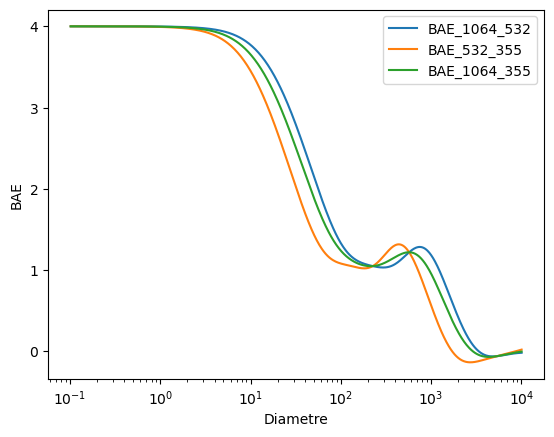

In [35]:
# Affichage des données précédentes
plt.semilogx(diam_entree, BAE_1064_532, label="BAE_1064_532")
plt.semilogx(diam_entree, BAE_532_355, label="BAE_532_355")
plt.semilogx(diam_entree, BAE_1064_355, label="BAE_1064_355")
plt.xlabel("Diametre")
plt.ylabel("BAE")
plt.legend()
plt.show()

313/313 [==============================] - 0s 652us/step


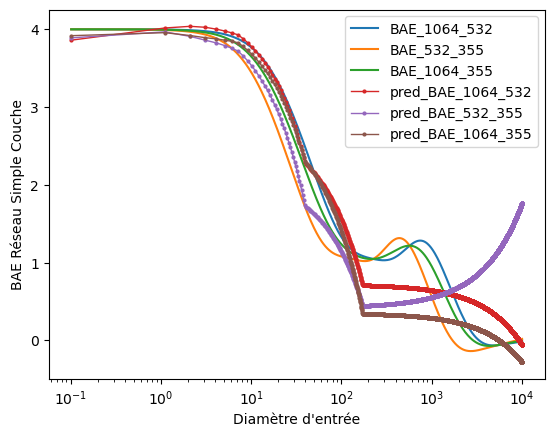

In [39]:
inputs = diam_entree.reshape(-1, 1) # convertir en format pour le réseau de neurones
outputs = np.column_stack((BAE_1064_532, BAE_532_355, BAE_1064_355))

# Modèle du réseau de neurones
model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(1,)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(3)
])
# Compilation du modèle
model.compile(optimizer='adam', loss='mean_squared_error')

# Entraînement du modèle
model.fit(inputs, outputs, epochs=100, verbose=0)

# Génération de nouvelles données pour tracer les prédictions
diametre_nouveau = np.linspace(np.min(diam_entree), np.max(diam_entree), 10000)
BAE_nouveau = model.predict(diametre_nouveau.reshape(-1, 1))

# Tracé des prédictions
plt.semilogx(diam_entree, BAEs[:,[0,1,2]], label= ["BAE_1064_532","BAE_532_355","BAE_1064_355"])
plt.semilogx(diametre_nouveau, BAE_nouveau, 'o-', lw=1, ms=2, label=["pred_BAE_1064_532","pred_BAE_532_355","pred_BAE_1064_355"])
plt.xlabel("Diamètre d'entrée")
plt.ylabel("BAE Réseau Simple Couche")
plt.legend()
plt.show()

Erreur d'entraînement : 0.9999975024512736
Erreur de validation : 0.999983508683918
313/313 [==============================] - 0s 676us/step


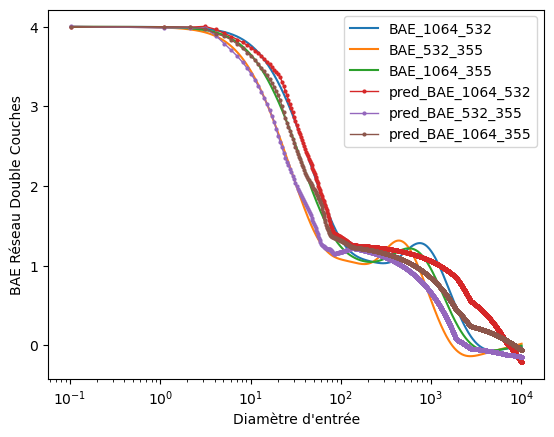

In [38]:
# Séparation des données en entrée et sortie
input_d = np.column_stack((diam_entree, np.full((diam_entree.shape[0], 1), sig),
                              np.full((diam_entree.shape[0], 1), indreal),
                              np.full((diam_entree.shape[0], 1), indimg)))

output_d = np.column_stack((BAE_1064_532, BAE_532_355, BAE_1064_355))

train_input, val_input, train_output, val_output = train_test_split(input_d, output_d, test_size=0.2, random_state=42) 
# Séparer les données

# Création du modèle de réseau de neurones
model = keras.Sequential()
model.add(keras.layers.Dense(32, input_shape=(4,), activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='linear'))

# Compilation du modèle
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Entraînement du modèle
history = model.fit(train_input, train_output, epochs=100, verbose=0, validation_data=(val_input, val_output))

# Évaluation du modèle
_, train_mae = model.evaluate(train_input, train_output, verbose=0)
_, val_mae = model.evaluate(val_input, val_output, verbose=0)
print("Erreur d'entraînement :", train_error)
print("Erreur de validation :", val_error)

# Génération de nouvelles données pour tracer les prédictions
diametre_nouveau = np.linspace(np.min(diam_entree), np.max(diam_entree), 10000)
input_nouveau = np.column_stack((diametre_nouveau, np.full((diametre_nouveau.shape[0], 1), sig),
                              np.full((diametre_nouveau.shape[0], 1), indreal),
                              np.full((diametre_nouveau.shape[0], 1), indimg)))
BAE_nouveau = model.predict(input_nouveau)


# Tracé des prédictions
plt.semilogx(diam_entree, BAEs[:,[0,1,2]], label= ["BAE_1064_532","BAE_532_355","BAE_1064_355"])
plt.semilogx(diametre_nouveau, BAE_nouveau, 'o-', lw=1, ms=2, label=["pred_BAE_1064_532","pred_BAE_532_355","pred_BAE_1064_355"])
plt.xlabel("Diamètre d'entrée")
plt.ylabel("BAE Réseau Double Couches")
plt.legend()
plt.show()

Erreur d'entraînement : 0.9999975024512736
Erreur de validation : 0.999983508683918


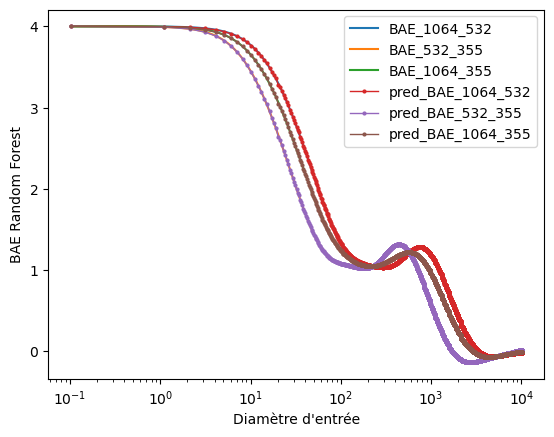

In [37]:
# Séparation des données en entrée et sortie
input_d = np.column_stack((diam_entree, np.full((diam_entree.shape[0], 1), sig),
                              np.full((diam_entree.shape[0], 1), indreal),
                              np.full((diam_entree.shape[0], 1), indimg)))

output_d = np.column_stack((BAE_1064_532, BAE_532_355, BAE_1064_355))

# Séparation des données en ensemble d'entraînement et de validation
train_input, val_input, train_output, val_output = train_test_split(input_d, output_d, test_size=0.2, random_state=42) 

# Création du modèle random forest
model = RandomForestRegressor(n_estimators=100)

# Entraînement du modèle
model.fit(train_input, train_output)

# Évaluation du modèle
train_error = model.score(train_input, train_output)
val_error = model.score(val_input, val_output)
print("Erreur d'entraînement :", train_error)
print("Erreur de validation :", val_error)

# Génération de nouvelles données pour tracer les prédictions
diametre_nouveau = np.linspace(np.min(diam_entree), np.max(diam_entree), 10000)
input_nouveau = np.column_stack((diametre_nouveau, np.full((diametre_nouveau.shape[0], 1), sig),
                              np.full((diametre_nouveau.shape[0], 1), indreal),
                              np.full((diametre_nouveau.shape[0], 1), indimg)))
BAE_nouveau = model.predict(input_nouveau)


# Tracé des prédictions
plt.semilogx(diam_entree, BAEs[:,[0,1,2]], label= ["BAE_1064_532","BAE_532_355","BAE_1064_355"])
plt.semilogx(diametre_nouveau, BAE_nouveau, 'o-', lw=1, ms=2, label=["pred_BAE_1064_532","pred_BAE_532_355","pred_BAE_1064_355"])
plt.xlabel("Diamètre d'entrée")
plt.ylabel("BAE Random Forest")
plt.legend()
plt.show()

[20:06:58] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Erreur d'entraînement : 0
Erreur de validation : 0


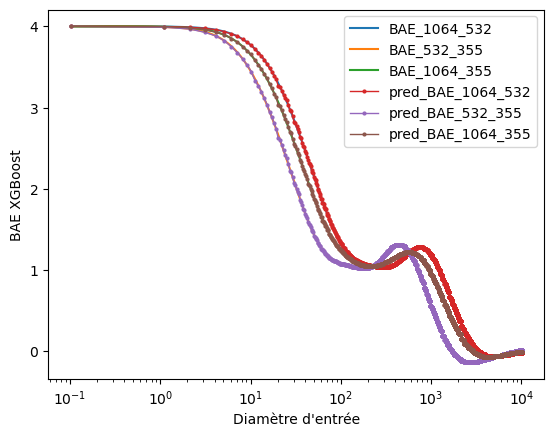

In [36]:
# Séparation des données en entrée et sortie
diam_entree = diam_entree.reshape(-1, 1)
BAE_sortie = np.array(BAEs)

# Séparation des données en ensemble d'entraînement et de validation
train_input, val_input, train_output, val_output = train_test_split(diam_entree, BAEs, test_size=0.2, random_state=42) 

# Conversion des données en format Dmatrix pour XGBoost
dtrain = xgb.DMatrix(train_input, label=train_output)
dval = xgb.DMatrix(val_input, label=val_output)

# Paramétrage de XGBoost
params = {'objective': 'reg:linear',
          'eval_metric': 'rmse',
          'seed': 42}

# Entraînement du modèle
model = xgb.train(params, dtrain, num_boost_round=100)

# Évaluation du modèle
train_error = model.eval(dtrain)[1]
val_error = model.eval(dval)[1]
print("Erreur d'entraînement :", train_error)
print("Erreur de validation :", val_error)

# Génération de nouvelles données pour tracer les prédictions
diametre_nouveau = np.linspace(np.min(diam_entree), np.max(diam_entree), 10000).reshape(-1, 1)
dtest = xgb.DMatrix(diametre_nouveau)
BAE_nouveau = model.predict(dtest)

# Tracé des prédictions
plt.semilogx(diam_entree, BAEs[:,[0,1,2]], label= ["BAE_1064_532","BAE_532_355","BAE_1064_355"])
plt.semilogx(diametre_nouveau, BAE_nouveau, 'o-', lw=1, ms=2, label=["pred_BAE_1064_532","pred_BAE_532_355","pred_BAE_1064_355"])
plt.xlabel("Diamètre d'entrée")
plt.ylabel("BAE XGBoost")
plt.legend()
plt.show()

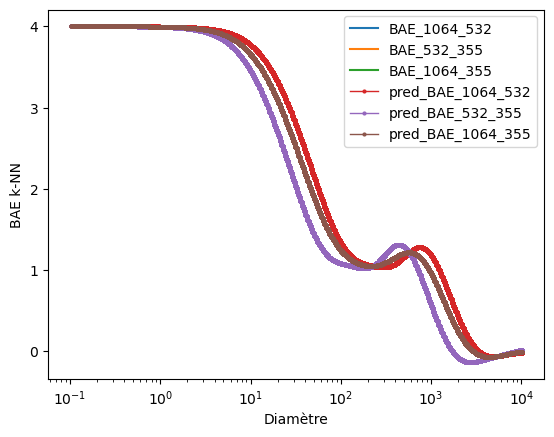

38.05651593208313


In [31]:
diam_entree = diam_entree.reshape(-1, 1)
BAE_sortie = np.array(BAEs)

# Instancier et entrainer le modèle k-NN
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(diam_entree, BAE_sortie)

# Prédire les valeurs de BAE en utilisant le modèle k-NN
diam_pred = np.linspace(diam_entree.min(), diam_entree.max(), 10000000).reshape(-1, 1)
BAE_pred = knn.predict(diam_pred)

# Afficher les courbes de prédiction
plt.semilogx(diam_entree, BAE_sortie, label= ["BAE_1064_532","BAE_532_355","BAE_1064_355"])
plt.semilogx(diam_pred, BAE_pred, 'o-', lw=1, ms=2, label=["pred_BAE_1064_532","pred_BAE_532_355","pred_BAE_1064_355"])
plt.xscale('log')
plt.xlabel('Diamètre')
plt.ylabel('BAE k-NN')
plt.legend()
plt.show()

C:\Users\thoma\AppData\Local\Temp\ipykernel_2460\532236933.py:6: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 0.7)


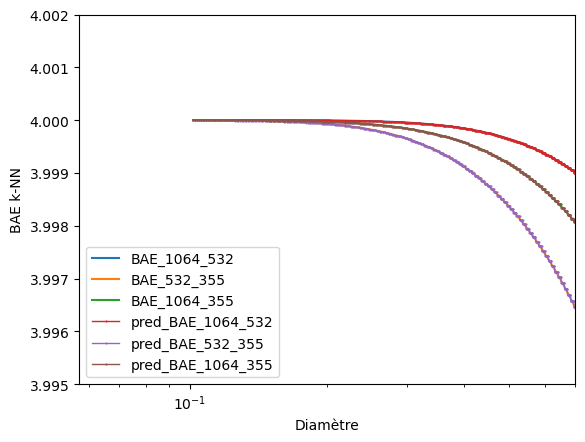

In [29]:
plt.semilogx(diam_entree, BAE_sortie, label= ["BAE_1064_532","BAE_532_355","BAE_1064_355"])
plt.semilogx(diam_pred, BAE_pred, 'o-', lw=1, ms=0.5, label=["pred_BAE_1064_532","pred_BAE_532_355","pred_BAE_1064_355"])
plt.xscale('log')
plt.xlabel('Diamètre')
plt.ylabel('BAE k-NN')
plt.xlim(0, 0.7)
plt.ylim(3.995, 4.002)
plt.legend()
plt.show()